In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/raw/employee_data.csv')


Feature Engineering
1. Generate new features.


In [3]:
# Calculate tenure ratios
df['TenureRatio'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 1e-5)  # Adding small value to avoid division by zero
df['YearsInRoleRatio'] = df['YearsInCurrentRole'] / (df['YearsAtCompany'] + 1e-5)


In [4]:
# Interaction terms
df['JobLevel_MonthlyIncome'] = df['JobLevel'] * df['MonthlyIncome']



2. Perform Feature Selection


In [5]:
fdf = df

In [6]:
binary_columns = ['Attrition', 'OverTime', 'Gender' ]
for col in binary_columns:
    fdf[col] = fdf[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})  # Adjust mappings as per column values


In [12]:
fdf = pd.get_dummies(fdf, drop_first=True)

In [7]:
fdf.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'TenureRatio', 'YearsInRoleRatio',
       'JobLevel_MonthlyIncome'],
      dtype='object')

In [8]:
fdf

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,TenureRatio,YearsInRoleRatio,JobLevel_MonthlyIncome
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,8,0,1,6,4,0,5,0.749999,0.666666,11986
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,10,3,3,10,7,1,7,0.999999,0.699999,10260
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,7,3,3,0,0,0,0,0.000000,0.000000,2090
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,8,3,3,8,7,3,0,0.999999,0.874999,2909
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,6,3,3,2,2,2,2,0.333333,0.999995,3468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,17,3,3,5,2,0,3,0.294117,0.399999,5142
1466,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,9,5,3,7,7,1,7,0.777777,0.999999,29973
1467,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,6,0,3,6,2,0,3,0.999998,0.333333,12284
1468,49,0,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,17,3,2,9,6,0,8,0.529411,0.666666,10780


2. Use SMOTE for Oversampling

In [13]:
from imblearn.over_sampling import SMOTE

# Separate features and target
X = fdf.drop(columns=['Attrition'])  # Features
y = fdf['Attrition']  # Target

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
from collections import Counter
print("Resampled class distribution:", Counter(y_resampled))


Resampled class distribution: Counter({1: 1233, 0: 1233})


Perform feature selection.
1. Use methods like Recursive Feature Elimination (RFE) or Feature Importance from Random Forest.

In [14]:
# Recursive Feature Elimination (RFE): RFE iteratively removes the least important features based on a model's performance.

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Initialize RFE
rfe = RFE(estimator=rf_model, n_features_to_select=10)  # Select top 10 features
X = fdf.drop(columns=['Attrition'])  # Features
y = fdf['Attrition']  # Target

# Fit RFE
rfe.fit(X, y)

# Get selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['Age', 'DailyRate', 'DistanceFromHome', 'EmployeeNumber', 'HourlyRate',
       'MonthlyIncome', 'MonthlyRate', 'TotalWorkingYears', 'TenureRatio',
       'JobLevel_MonthlyIncome'],
      dtype='object')


In [15]:
# Feature Importance from Random Forest: Random Forest provides feature importance scores directly, ranking features by their contribution to reducing impurity.

# Fit the model
rf_model.fit(X, y)

# Get feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance_df.head(20))


                    Feature  Importance
30   JobLevel_MonthlyIncome    0.062685
12            MonthlyIncome    0.054992
15                 OverTime    0.052091
0                       Age    0.049376
1                 DailyRate    0.044984
13              MonthlyRate    0.044058
2          DistanceFromHome    0.041794
21        TotalWorkingYears    0.041108
8                HourlyRate    0.039807
5            EmployeeNumber    0.037811
24           YearsAtCompany    0.032824
28              TenureRatio    0.031304
14       NumCompaniesWorked    0.027032
16        PercentSalaryHike    0.026996
6   EnvironmentSatisfaction    0.026897
29         YearsInRoleRatio    0.026384
20         StockOptionLevel    0.025875
27     YearsWithCurrManager    0.024934
23          WorkLifeBalance    0.022203
11          JobSatisfaction    0.021633


In [16]:
# Correlation-Based Selection: Remove highly correlated features to avoid redundancy.

# Compute correlation matrix
correlation_matrix = fdf.corr()

# Identify highly correlated features
threshold = 0.85  # Set correlation threshold
high_correlation = correlation_matrix.abs() > threshold
correlated_features = set()

for i in range(len(high_correlation.columns)):
    for j in range(i):
        if high_correlation.iloc[i, j]:
            correlated_features.add(high_correlation.columns[i])

print("Highly Correlated Features:", correlated_features)


Highly Correlated Features: {'Department_Sales', 'JobLevel_MonthlyIncome', 'MonthlyIncome'}


Model Building
1. Train Initial Models Using Different Algorithms

In [17]:
# Train multiple models to evaluate their performance and select the best-performing one.

# 1. Prepare the Dataset Ensure the dataset is split into training and testing sets.

from sklearn.model_selection import train_test_split

# Split the data
X = fdf.drop(columns=['Attrition'])  # Features
y = fdf['Attrition']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [18]:
# 2. Train Models Train Logistic Regression, Decision Tree, Random Forest, and XGBoost models.

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained successfully.")


c:\Users\muzam\OneDrive\Desktop\Attrition-Analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression trained successfully.
Decision Tree trained successfully.
Random Forest trained successfully.
XGBoost trained successfully.


c:\Users\muzam\OneDrive\Desktop\Attrition-Analysis\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Define evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }

# Perform evaluation
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f}")
    results[name] = evaluate_model(model, X_test, y_test)

# Display evaluation metrics
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)


c:\Users\muzam\OneDrive\Desktop\Attrition-Analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\muzam\OneDrive\Desktop\Attrition-Analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Logistic Regression Cross-Validation Accuracy: 0.8376
Decision Tree Cross-Validation Accuracy: 0.7866
Random Forest Cross-Validation Accuracy: 0.8580


c:\Users\muzam\OneDrive\Desktop\Attrition-Analysis\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\muzam\OneDrive\Desktop\Attrition-Analysis\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\muzam\OneDrive\Desktop\Attrition-Analysis\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder"

XGBoost Cross-Validation Accuracy: 0.8631
                     Accuracy  Precision    Recall  F1 Score   ROC-AUC
Logistic Regression  0.846939   1.000000  0.042553  0.081633  0.599276
Decision Tree        0.782313   0.333333  0.361702  0.346939  0.612025
Random Forest        0.836735   0.454545  0.106383  0.172414  0.780601
XGBoost              0.857143   0.631579  0.255319  0.363636  0.798174


c:\Users\muzam\OneDrive\Desktop\Attrition-Analysis\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Hyperparameter Tuning
1. Perform hyperparameter optimization using Grid Search or Random Search.

In [20]:
# Random Search (Faster Alternative)
# Randomly samples combinations of hyperparameters.

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize model
xgb_model = XGBClassifier(random_state=42)

# Perform Random Search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1', verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best F1 Score: 0.48178990339834266


2. Use advanced optimization methods like Bayesian Optimization (optional).


In [21]:
#  Bayesian Optimization (Advanced)
# Uses probability models to find the best hyperparameters iteratively.
# Tools: Optuna, Scikit-Optimize.

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = XGBClassifier(**params, random_state=42)
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best F1 Score:", study.best_value)


c:\Users\muzam\OneDrive\Desktop\Attrition-Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-08 18:50:21,128] A new study created in memory with name: no-name-f08aae83-fb5e-4e90-ae34-60792584716e
[I 2024-12-08 18:50:22,726] Trial 0 finished with value: 0.42770989676977555 and parameters: {'n_estimators': 329, 'max_depth': 5, 'learning_rate': 0.06311708616240894, 'subsample': 0.697694253337355, 'colsample_bytree': 0.8867514749652644}. Best is trial 0 with value: 0.42770989676977555.
[I 2024-12-08 18:50:23,385] Trial 1 finished with value: 0.40510337468320656 and parameters: {'n_estimators': 151, 'max_depth': 3, 'learning_rate': 0.050056992112997606, 'subsample': 0.8473691511061046, 'colsample_bytree': 0.8519436532647988}. Best is trial 0 with value: 0.42770989676977555.
[I 2024-12-08 18:50:24

Best Parameters: {'n_estimators': 362, 'max_depth': 5, 'learning_rate': 0.27294285443692917, 'subsample': 0.7886015416197366, 'colsample_bytree': 0.7110331181389234}
Best F1 Score: 0.511701123735022


Model Evaluation and Insights
1. Interpret model results.

In [22]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

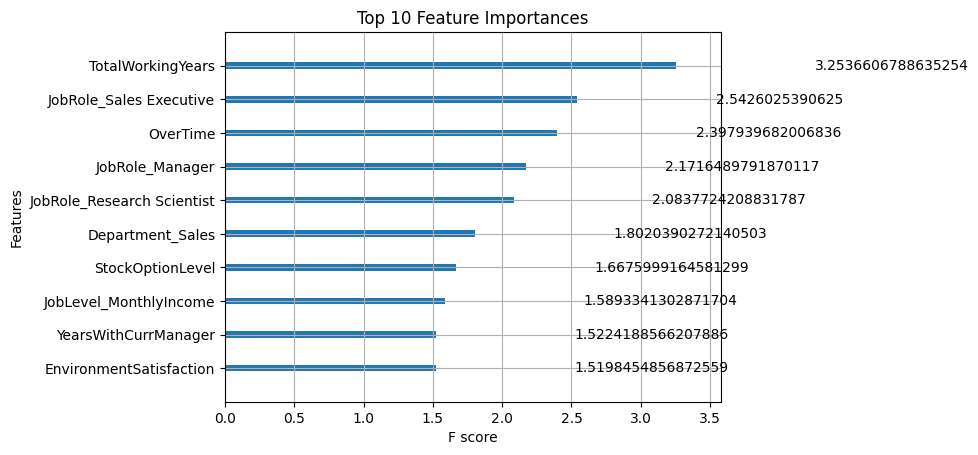

In [23]:
# Analyze feature importance to determine factors most influencing attrition.

import matplotlib.pyplot as plt
import xgboost as xgb

# Extract feature importance from the trained XGBoost model
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()


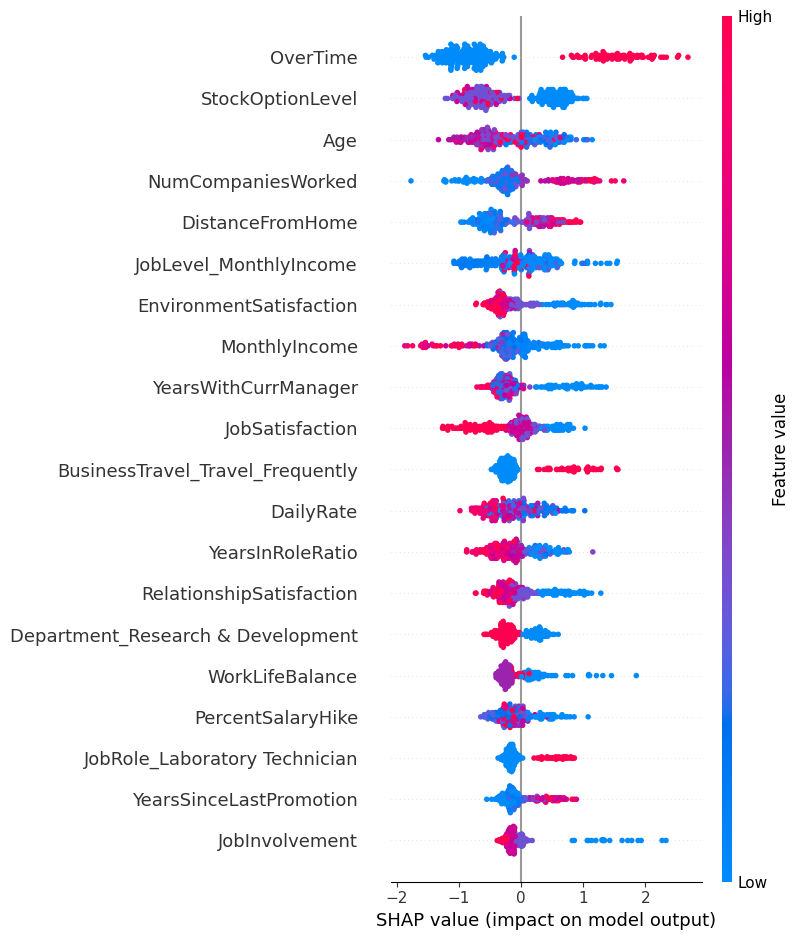

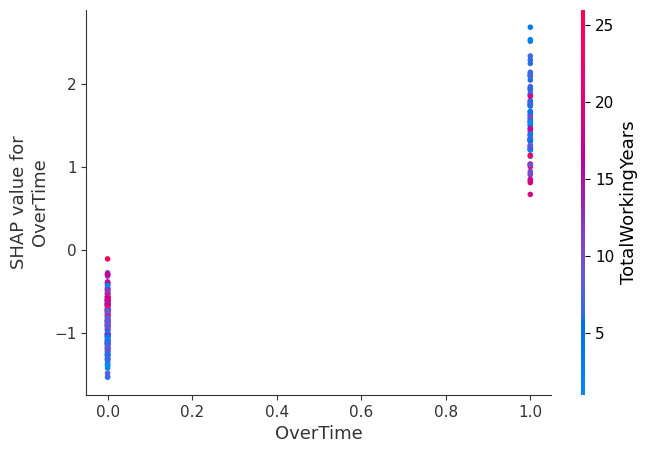

In [24]:
# Generate SHAP values for feature impact explanations.

import shap

# Initialize SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Dependence plot for a specific feature
shap.dependence_plot("OverTime", shap_values, X_test)


In [25]:
# Interpret the SHAP output:

# Identify features with the highest average SHAP values (e.g., "OverTime," "JobLevel," "MonthlyIncome").
# Explain their effect on attrition:
# OverTime: Employees working overtime are more likely to leave.
# JobLevel: Higher job levels may have a lower attrition rate.
# MonthlyIncome: Dissatisfaction due to lower income might contribute to higher attrition.

2. Test model performance on a hold-out test dataset.

In [26]:
# Validate XGBoost prformance

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict on test data
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))


Accuracy: 0.8571428571428571
Precision: 0.631578947368421
Recall: 0.2553191489361702
F1 Score: 0.36363636363636365
ROC-AUC: 0.7981738306486346


In [66]:
# Key Features Driving Attrition:

# Highlight the top 5 features influencing attrition and their impact directions (e.g., "OverTime" increases attrition risk).
# Actionable Recommendations:

# Reduce overtime for employees.
# Address pay gaps for low-income groups.
# Implement retention strategies for specific job roles or departments.
# Model Performance:

# Report metrics like Accuracy, F1 Score, and ROC-AUC on test data to confirm XGBoost's effectiveness.

Machine Learning  Model Production

Data Preparation for Modeling
1. Implement scalable preprocessing pipelines.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer



In [ ]:
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes('bool').columns})


NameError: name 'X_train' is not defined

In [ ]:
# Handle boolean columns explicitly
bool_transformer = Pipeline(steps=[
    ('convert', FunctionTransformer(lambda x: x.astype(int)))
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('bool', bool_transformer, X_train.select_dtypes('bool').columns),
    ('num', num_transformer, X_train.select_dtypes(include=['int64', 'float64']).columns),
    ('cat', cat_transformer, X_train.select_dtypes('object').columns)
])

In [ ]:
# Define Feature Categories Categorize your features into numerical and categorical groups:

# Identify feature types
numerical_features = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'TotalWorkingYears']
categorical_features = [
    'BusinessTravel_Travel_Rarely', 
    'BusinessTravel_Travel_Frequently', 
    'Department_Research & Development', 'Department_Sales', 
    'EducationField_Life Sciences', 'EducationField_Marketing',
    'EducationField_Medical', 'EducationField_Other',
    'EducationField_Technical Degree', 
    'JobRole_Human Resources',
    'JobRole_Laboratory Technician', 'JobRole_Manager',
   'JobRole_Manufacturing Director', 'JobRole_Research Director',
    'JobRole_Research Scientist', 'JobRole_Sales Executive',
   'JobRole_Sales Representative', 
    'MaritalStatus_Married',
    'MaritalStatus_Single'
]

In [ ]:
# Set Up Transformers Define transformations for each type of feature:

# Numerical Transformer
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical Transformer
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [ ]:
# Combine Transformers Using ColumnTransformer Use ColumnTransformer to apply transformations to the respective feature types:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features)
    ]
)



In [ ]:
# Create the Full Pipeline Combine the preprocessing steps with a machine learning model in a single pipeline:

from sklearn.ensemble import RandomForestClassifier

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


2. Create and validate train-test splits.

In [ ]:
# Train and Evaluate the Model Fit the pipeline on training data and evaluate its performance:

# Fit the pipeline
model_pipeline.fit(X_train, y_train)

# Evaluate the model
accuracy = model_pipeline.score(X_test, y_test)
print(f'Model Accuracy: {accuracy:.2f}')


Model Accuracy: 0.81


In [ ]:
# Ensure consistent stratification of Attrition for balanced test sets.

from sklearn.model_selection import train_test_split

# Assuming your features are stored in X (input data) and the target in y (Attrition)
X = fdf.drop(columns=['Attrition'])  # Features
y = fdf['Attrition']  # Target variable

# Split the data into training and testing sets with stratification on 'Attrition'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify the distribution of 'Attrition' in both training and test sets
print("Training set distribution:\n", y_train.value_counts(normalize=True))
print("Test set distribution:\n", y_test.value_counts(normalize=True))


Training set distribution:
 Attrition
0    0.838435
1    0.161565
Name: proportion, dtype: float64
Test set distribution:
 Attrition
0    0.840136
1    0.159864
Name: proportion, dtype: float64


In [77]:
import pickle

# Save the model using pickle
with open('attrition_model.pkl', 'wb') as model_file:
    pickle.dump(model_pipeline, model_file)

print("Model saved successfully!")

Model saved successfully!
